In [1]:
# Generales
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pydot as pyd
import time
import joblib

# image preprocessing
import os
import sys
import shutil
import glob
import matplotlib.image as mpimg
from PIL import Image

#sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#keras
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout, BatchNormalization
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils.vis_utils import plot_model

# tensorflow
import tensorflow as tf
from tensorflow.random import set_seed

#cv2
import cv2
from google.colab.patches import cv2_imshow

In [3]:
%env name=samples1_512
!echo $name

env: name=samples1_512
samples1_512


In [5]:
set_seed(42)
np.random.seed(42)

In [6]:
# Constants

# dirs
inp_img_dir = "./samples/"
out_dir = ""

# init
start_num = 1

height, width = 32, 32

# placeholder
r = "rule_"

# all file names and classes
files = {'1':[], '2':[], '3':[], '4':[]}

# Classes
class1 = [0, 8, 32, 40, 128, 136, 160, 168]
class2 = [
          1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 19, 
          23, 24, 25, 26, 27, 28, 29, 33, 34, 35, 36, 37, 38, 
          42, 43, 44, 46, 50, 51, 56, 57, 58, 62, 72, 73, 74, 
          76, 77, 78, 94, 104, 108, 130, 132, 134, 138, 140, 
          142, 152, 154, 156, 162, 164, 170, 172, 178, 184, 
          200, 204, 232
        ]
class3 = [18, 22, 30, 45, 60, 90, 105, 122, 126, 146, 150]
class4 = [41, 54, 106, 110]

## Dataset Organization



In [7]:
def getPics(classRules, samplesDir):
    classImgs = []

    for r in classRules:
        imgsDir = samplesDir + f'rule_{str(r)}/' 
        classImgs += [imgsDir + f for f in os.listdir(imgsDir)]
    return classImgs


c1_img_list = getPics(class1, inp_img_dir)
c2_img_list = getPics(class2, inp_img_dir)
c3_img_list = getPics(class3, inp_img_dir)
c4_img_list = getPics(class4, inp_img_dir)

## Data Prep

In [8]:
len(c1_img_list), len(c2_img_list), len(c3_img_list), len(c4_img_list)

(16376, 16640, 14078, 16367)

In [9]:
files_target = [np.full(len(c1_img_list), '1', dtype=str), 
         np.full(len(c2_img_list), '2', dtype=str), 
         np.full(len(c3_img_list), '3', dtype=str), 
         np.full(len(c4_img_list), '4', dtype=str), 
         ]
[x.shape[0] for x in files_target]

[16376, 16640, 14078, 16367]

In [10]:
# Data selection
endl = len(c4_img_list)
c1_x = c1_img_list[:endl].copy()
c2_x = c2_img_list[:endl].copy()
c3_x = c3_img_list[:endl].copy()
c4_x = c4_img_list[:endl].copy()

c1_y = files_target[0][:endl].copy()
c2_y = files_target[1][:endl].copy()
c3_y = files_target[2][:endl].copy()
c4_y = files_target[3][:endl].copy()

In [11]:
len(c1_x),len(c2_x),len(c3_x),len(c4_x)

(16367, 16367, 14078, 16367)

In [12]:
c_x = np.array(c1_x+c2_x+c3_x+c4_x)
c_y = np.concatenate((c1_y,c2_y,c3_y,c4_y))

In [13]:
dataset = pd.DataFrame({'img':c_x, 'class':c_y})
dataset = dataset.sample(frac=1)
dataset

,img,class
39820,./samples/rule_90/90_000_0122_1673.png,3
39376,./samples/rule_90/90_000_0209_3583.png,3
57955,./samples/rule_106/106_000_0152_8748.png,4
51183,./samples/rule_54/54_000_0090_5626.png,4
60231,./samples/rule_110/110_000_0157_2223.png,4
...,...,...
62570,./samples/rule_110/110_000_0244_9339.png,4
38158,./samples/rule_60/60_000_0206_7583.png,3
860,./samples/rule_0/0_000_0096_7232.png,1
15795,./samples/rule_168/168_000_0215_3037.png,1


## Data Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(dataset['img'].values, dataset['class'].values, test_size=0.33, random_state=42)

# Reshape

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# one hot encoding
enc = OneHotEncoder(sparse=False)
enc.fit(y_train)

# save encode
joblib.dump(enc, '../encodings/encoder' + '_comelli_V2_' + '.joblib')

# transform data
y_train = enc.transform(y_train)

print(pd.DataFrame(y_train, columns=list(enc.categories_[0])).head())

# tranform encoding for test data
y_test = enc.transform(y_test)
# to print the encoded features for train data
print(pd.DataFrame(y_test, columns=list(enc.categories_[0])).head())

     1    2    3    4
0  1.0  0.0  0.0  0.0
1  0.0  0.0  0.0  1.0
2  0.0  0.0  1.0  0.0
3  0.0  0.0  0.0  1.0
4  0.0  0.0  1.0  0.0
     1    2    3    4
0  0.0  0.0  1.0  0.0
1  0.0  1.0  0.0  0.0
2  0.0  1.0  0.0  0.0
3  0.0  1.0  0.0  0.0
4  0.0  0.0  0.0  1.0


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
X_train[325], y_train[325]

('./samples/rule_18/18_000_0235_4630.png', array([0., 0., 1., 0.]))

## Images

In [16]:
def getImages(files):
    img_list = []

    for img in files:
        img1 = load_img(out_dir + img, color_mode='grayscale')
        x = img_to_array(img1) / 255      
        
        img_list.append(x)

    return np.array(img_list)

In [17]:
# Images Preview
def imagePreview(imgsArr):
    imgs_show = [imgsArr[0], imgsArr[50], imgsArr[2589], imgsArr[-4]]
    plt.figure(figsize=(16,8))
    columns = 4
    
    for i, image in enumerate(imgs_show):
        plt.subplot(len(imgs_show) // columns + 1, columns, i + 1)
        
        plt.imshow(array_to_img(image))

    plt.figure()
    plt.show()

In [18]:
X_train = getImages(X_train)

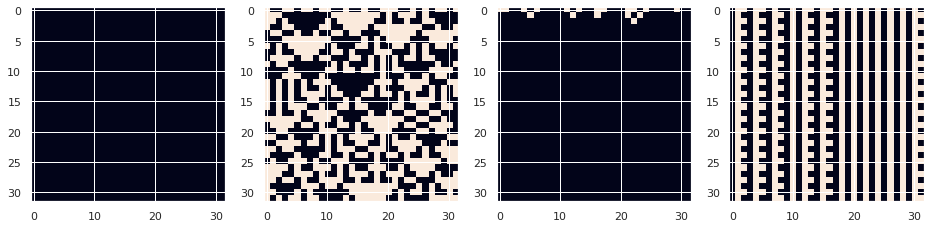

<Figure size 432x288 with 0 Axes>

In [19]:
imagePreview(X_train)

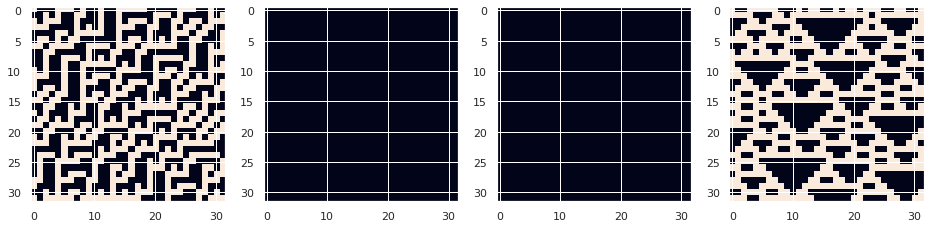

<Figure size 432x288 with 0 Axes>

In [20]:
X_test = getImages(X_test)

imagePreview(X_test)

In [21]:
X_train[0].shape

(32, 32, 1)

## Training

In [22]:
# parameters
kernel = 3
stride = 2

# input
inputs_conv1 = keras.Input(shape=(height, width, 1), name='conv1')

# CNN
conv1 = Conv2D(32, kernel, activation='relu', name='conv2')(inputs_conv1)
pool1 = MaxPooling2D(stride, name='pool1')(conv1)
conv1 = Conv2D(32, kernel, activation='relu',name='conv3')(pool1)

flat = Flatten(name='flt')(conv1)

dense = Dense(64, activation='relu', name='dense')(flat)

# out
output = Dense(4, activation='softmax', name='out')(dense)


model = Model(inputs=inputs_conv1, outputs=output)

model.build((None,height,width,1))

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (InputLayer)          [(None, 32, 32, 1)]       0         
                                                                 
 conv2 (Conv2D)              (None, 30, 30, 32)        320       
                                                                 
 pool1 (MaxPooling2D)        (None, 15, 15, 32)        0         
                                                                 
 conv3 (Conv2D)              (None, 13, 13, 32)        9248      
                                                                 
 flt (Flatten)               (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 64)                346176    
                                                                 
 out (Dense)                 (None, 4)                 260   

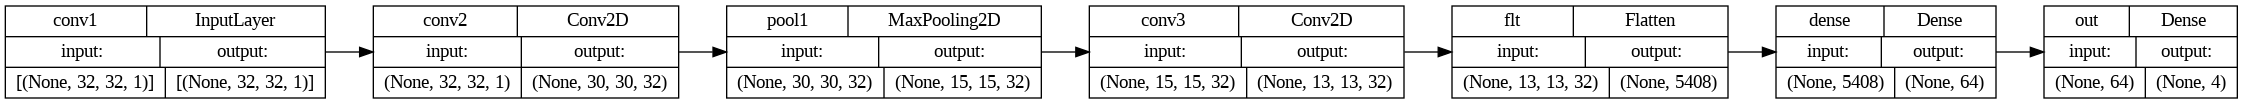

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

In [25]:
# Model
save_dir = '../saved_models/comelli_V2_best.h5'

# 1e-2
opt = Adam(learning_rate=1e-2, amsgrad=True)
met = tf.keras.metrics.CategoricalAccuracy()

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=[met]
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir, 
                            monitor='val_categorical_accuracy', verbose=1, 
                            save_best_only=True, mode='max')

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', 
                                      min_delta=0.05, verbose=1, patience=15)

callbacks_list = [checkpoint, es]

hist = model.fit(        
    x = X_train,
    y = y_train,
    validation_data=([X_test], y_test),
    # ep 50, b 12
    epochs=200,
    batch_size=64,
    verbose=1,
    callbacks=callbacks_list
)

Epoch 1/200
662/662 [==============================] - ETA: 0s - loss: 0.2388 - categorical_accuracy: 0.9193
Epoch 1: val_categorical_accuracy improved from -inf to 0.97559, saving model to ./drive/Shareddrives/Memoria/code/best_models/comelli_V2_best.h5
662/662 [==============================] - 17s 9ms/step - loss: 0.2388 - categorical_accuracy: 0.9193 - val_loss: 0.1071 - val_categorical_accuracy: 0.9756
Epoch 2/200
651/662 [============================>.] - ETA: 0s - loss: 0.0753 - categorical_accuracy: 0.9822
Epoch 2: val_categorical_accuracy improved from 0.97559 to 0.98508, saving model to ./drive/Shareddrives/Memoria/code/best_models/comelli_V2_best.h5
662/662 [==============================] - 4s 5ms/step - loss: 0.0755 - categorical_accuracy: 0.9821 - val_loss: 0.0694 - val_categorical_accuracy: 0.9851
Epoch 3/200
653/662 [============================>.] - ETA: 0s - loss: 0.0610 - categorical_accuracy: 0.9865
Epoch 3: val_categorical_accuracy improved from 0.98508 to 0.98585,

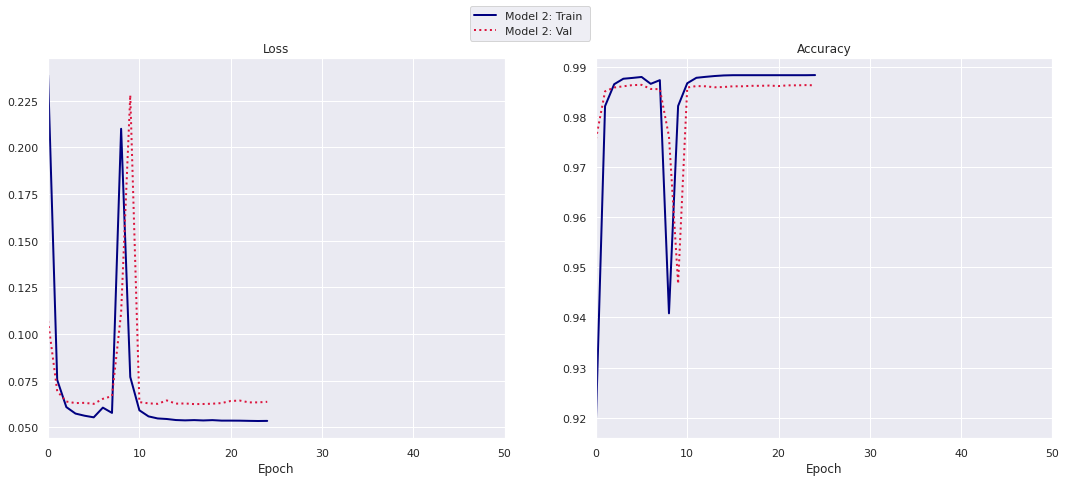

In [26]:
fig = plt.figure(figsize=(18, 7), facecolor='w', edgecolor='k')
gs  = gridspec.GridSpec(nrows=1, ncols=2)
ax = plt.subplot(gs[0, 0]), plt.subplot(gs[0, 1])

colors_list = ["crimson", "orchid", "navy", "aqua"]

num=2
l1 = ax[0].plot(hist.history['loss'], c=colors_list[num] ,label='Model '+str(num)+': Train ', linewidth=2)
ax[0].plot(hist.history['val_loss'], ls='dotted', c=colors_list[0], label='Model '+str(num)+': Val', linewidth=2)

ax[1].plot(hist.history['categorical_accuracy'], c=l1[0].get_color(), linewidth=2)
ax[1].plot(hist.history['val_categorical_accuracy'], ls='dotted', c=colors_list[0], linewidth=2)

# labels
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_xlim([0, 50])
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_xlim([0, 50])

handles, labels = ax[0].get_legend_handles_labels()
plt.legend(labels, loc="best", bbox_to_anchor=(0, 1.15))
plt.show()